## Chapter 3 : Labeling<a name='top'></a>
+ [3-1-a](#e_3_1_a)
+ [3-1-b](#e_3_1_b)
+ [3-1-c](#e_3_1_c)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import mlfinlab as fl

import itertools as it 

def npMovingAverage(data, window=3):
    weights = np.ones(window) / window
    return np.convolve(data, weights, mode='valid')

def getDailityVol (
    df,
    col_close='close',
    col_dVol='dVol',
    span0 = 100
    ):
    df[col_dVol]=df[col_close].pct_change()
    df[col_dVol] = df[col_dVol].ewm(span=100).std()
    return df[col_dVol]

In [2]:
from mlfinlab.filters.filters import cusum_filter
from mlfinlab.labeling.labeling import add_vertical_barrier, get_events, get_bins, drop_labels
from mlfinlab.util.utils import get_daily_vol

### [class pandas.Timedelta](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Timedelta.html)
Represents a duration, the difference between two dates or times.

Timedelta is the pandas equivalent of python’s datetime.timedelta and is interchangeable with it in most cases.

Parameters:	
value : Timedelta, timedelta, np.timedelta64, string, or integer
unit : string, {‘ns’, ‘us’, ‘ms’, ‘s’, ‘m’, ‘h’, ‘D’}, optional

Denote the unit of the input, if input is an integer. Default ‘ns’.

days, seconds, microseconds,
milliseconds, minutes, hours, weeks : numeric, optional

Values for construction in compat with datetime.timedelta. np ints and floats will be coereced to python ints and floats.

### SNIPPET 3.1 Daily Volaitility Estimates<a name='s_3_1'></a>
+ compute the daility volatility at intraday estimation points
+ apply a sapn of ```span0``` days to an EWMstd
+ see [pandas.Series.ewm](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.ewm.html)

```python
def getDailityVol (close, span0 = 100):
    # daily vol, redindexed to close
    df0.close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0>0]
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0],df0.shape[0],:])
    df0 = close.loc[df0.index]/close.loc[df0.values].values-1 # dailiy returns
    df0 = df0.ewm(sapn = span0).std()
    return df0
```
    

In [243]:
def getDailityVol (
    df,
    col_close='close',
    col_dVol='dVol',
    span = 100
    ):
    df[col_dVol]=df[col_close].pct_change()
    df[col_dVol] = df[col_dVol].ewm(span=100).std()
    return df[col_dVol]

In [244]:
df = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
dVol = getDailityVol(df,span=20,col_close='price')
dVol.head()

#df['price'].index.searchsorted(df.index - pd.Timedelta(days=1))

timestamp
2018-11-21 09:02:00         NaN
2018-11-21 09:06:00         NaN
2018-11-21 09:11:00    0.000399
2018-11-21 09:19:00    0.000390
2018-11-21 09:33:00    0.000681
Name: dVol, dtype: float64

### SNIPPET 3.2 TRIPLE-BARRIER LABELING METHOD
```python
def applyPtSlOnT1(close,events,ptSl,molecule):
# apply stop loss/profit taking, if it takes place before t1 (end of event)
events_=events.loc[molecule]
out=events_[['t1']].copy(deep=True)
if ptSl[0]>0:pt=ptSl[0]*events_['trgt']
else:pt=pd.Series(index=events.index) # NaNs
if ptSl[1]>0:sl=-ptSl[1]*events_['trgt']
else:sl=pd.Series(index=events.index) # NaNs
for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
df0=close[loc:t1] # path prices
df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss.
out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking.
return out
```

### SNIPPET 3.3 GETTING THE TIME OF FIRST TOUCH
```python
def getEvents(close,tEvents,ptSl,trgt,minRet,numThreads,t1=False):
#1) get target
trgt=trgt.loc[tEvents]
trgt=trgt[trgt>minRet] # minRet
#2) get t1 (max holding period)
if t1 is False:t1=pd.Series(pd.NaT,index=tEvents)
#3) form events object, apply stop loss on t1
side_=pd.Series(1.,index=trgt.index)
events=pd.concat({'t1':t1,'trgt':trgt,'side':side_}, \
axis=1).dropna(subset=['trgt'])
df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index), \
numThreads=numThreads,close=close,events=events,ptSl=[ptSl,ptSl])
events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
events=events.drop('side',axis=1)
return events
```

### SNIPPET 3.4 ADDING A VERTICAL BARRIER<a name='s_3_4'></a>

```python
t1 = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
t1 = t1[t1< close.shape[0]]
t1= pd.Series(close.index[t1],index=tEvents[:t1.shape[0]])# NaNs at end
```

### SNIPPET 3.5 LABELING FOR SIDE AND SIZE
```python
def getBins(events,close):
#1) prices aligned with events
events_=events.dropna(subset=['t1'])
px=events_.index.union(events_['t1'].values).drop_duplicates()
px=close.reindex(px,method='bfill')
#2) create out object
out=pd.DataFrame(index=events_.index)
out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
out['bin']=np.sign(out['ret'])
return out
```

일단 CUSUM 부터 제대로  

$S_t \geq \max\{0,S_{t-1} + y_t - E_{t-1}[y_t]\}$  

이렇게 되어 있는데, finlab이나 교수님코드나 $- E_{t-1}[y_t]$ 부분이 안보인다

In [235]:
def CUSUM_3(
    df,
    col='close',
    h=0.05
   ):

    # tmp = np.log(df[col]).diff().fillna(0)
    tmp = np.log(df[col]).diff()
    tmp = tmp.dropna()
    tmp_p = list(it.accumulate(tmp, lambda x, y: max(x+y, 0) if (x+y) < h else 0))
    tmp_n = list(it.accumulate(tmp, lambda x, y: min(x+y, 0) if (x+y) < -h else 0))

    s1 = [index for index, value in enumerate(tmp_p) if value ==0]
    s2 = [index for index, value in enumerate(tmp_n) if value ==0]

    cu_set = (set(s1) & set(s2))
    cu_list = np.sort(list(cu_set),axis=0)
    s_t = df.iloc[cu3_list]
    
    return s_t

In [254]:
import numpy as np
import pandas as pd


# Snippet 2.4, page 39, The Symmetric CUSUM Filter.
def cusum_filter(raw_time_series, threshold, time_stamps=True):

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_time_series).diff()

    # Get event time stamps for the entire series
    for i in diff.index[1:]:
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    # Return DatetimeIndex or list
    if time_stamps:
        event_timestamps = pd.DatetimeIndex(t_events)
        return event_timestamps

    return t_events

'CUSUM3         : 706'

'mlfinlab CUSUM : 432'

0.16876474208660072

-0.037826608165119936

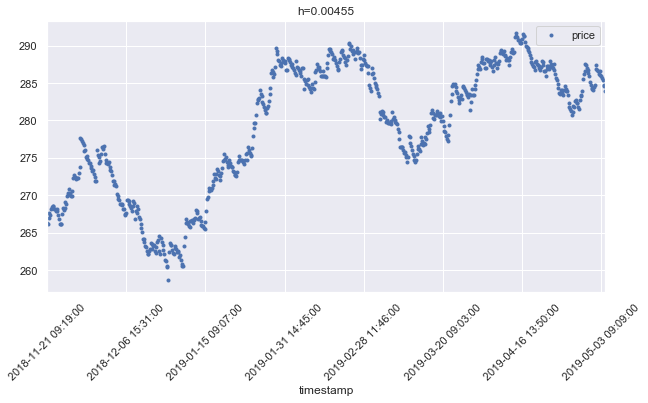

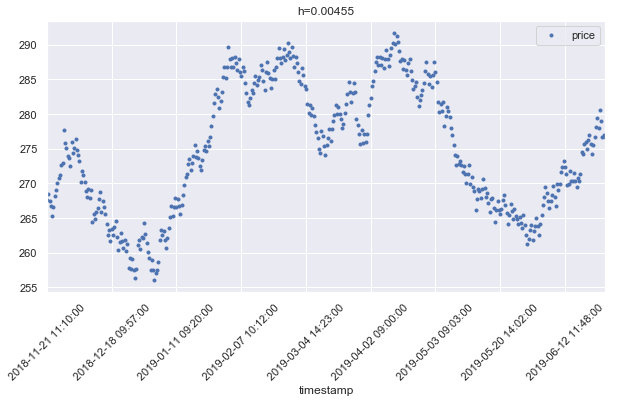

In [255]:
h_t = 0.00455
figsize=(10,5)
df = pd.read_csv('dollar_D_15.csv',index_col='timestamp')

s_t_1 = CUSUM_3(df,h=h_t,col='price')


fl_idx = fl.filters.cusum_filter(df, h_t , time_stamps=False)
s_t_2 = df[df.index.isin(fl_idx)]

display('CUSUM3         : ' +str(s_t_1.index.size))
display('mlfinlab CUSUM : ' +str(s_t_2.index.size))


r1 = s_t_1['price'].pct_change()
r2 =s_t_2['price'].pct_change()

display(r1.autocorr(lag=1))
display(r2.autocorr(lag=1))

s_t_1.plot(
    style='.',
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
    figsize=figsize,
    title='h=' + str(h_t) 
)
s_t_2.plot(
     style='.',
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
    figsize=figsize,
    title='h=' + str(h_t)
)

mlfinlab이 더 적게 잡음. 

$- E_{t-1}[y_t]$ 에 관해서는 좀 더 살펴보자  TODO

## Form Dollar bars for E-mini S&P 500 futures -> test.csv

## [EXERCISES 3.1.a](#top)<a name='e_3_1_a'></a>
Apply a symmetric CUSUM filter, where the thrshold is the standard deviation of dailty returns - [snippet 3.1](#s_3_1)

In [2]:
df3_1 = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
df3_1.head()

,price
timestamp,
2018-11-21 09:02:00,266.149994
2018-11-21 09:06:00,266.100006
2018-11-21 09:11:00,266.200012
2018-11-21 09:19:00,266.350006
2018-11-21 09:33:00,266.100006


In [3]:
def npMovingAverage(data, window=3):
    weights = np.ones(window) / window
    return np.convolve(data, weights, mode='valid')

def getDailityVol (
    df,
    col_close='close',
    col_dVol='dVol',
    span = 100
    ):
    dVol = df[col_close].pct_change()
    dVol = dVol.ewm(span=span).std()
    return dVol

def CUSUM_dVol(
    df,
    col='close',
    window=20,
   ):
    bar = df.drop(df.columns.difference([col]), axis=1)
    tmp = np.log(bar[col]).diff().fillna(0)
        
# ma = npMovingAverage(tmp,window)      
#    tmp = tmp[window-1:]
# tmp = tmp - ma   

    
    dVol = getDailityVol(df,span=20,col_close='price')
    dVol = dVol.dropna()
    display(dVol.head())
    display(tmp.head())
    #tmp_p = tmp - dVol
    tmp_p = tmp.sub(dVol, axis=0)
    
    display(tmp_p.head())
    tmp_n = tmp + dVol 
    
    
    tmp_p = tmp_p.dropna()
    tmp_n = tmp_n.dropna()
    #display(tmp_p.head())
    #display(tmp_n.head())
# tmp_p = list(it.accumulate(tmp_p, lambda x, y: max(x+y, 0) if (x+y) >= 0 else 0))
#    tmp_n = list(it.accumulate(tmp_n, lambda x, y: min(x+y, 0) if (x+y) <= 0 else 0))   
#    s1 = [index for index, value in enumerate(tmp_p) if value ==0]
#    s2 = [index for index, value in enumerate(tmp_n) if value ==0]

        
    tmp_p = list(it.accumulate(tmp_p, lambda x, y: max(x+y, 0) if (x+y) < 0 else 0))
    tmp_n = list(it.accumulate(tmp_n, lambda x, y: min(x+y, 0) if (x+y) < 0 else 0))
    
    s1 = [index for index, value in enumerate(tmp_p) if value ==0]
    s2 = [index for index, value in enumerate(tmp_n) if value ==0]
        
    s_p = bar.loc[s1]
    s_n = bar.loc[s2]    
    
    s_t = pd.concat([s_p,s_n],axis = 1,sort=True)
    s_t.columns = ['s_p','s_n']
    
    #s_t['s_t'] = s_t.apply(lambda x: x['s_n'] if pd.isna(x['s_p']) else x['s_p'],axis=1)
   # display(s_t)
    return s_t


In [4]:
# Snippet 2.4, page 39, The Symmetric CUSUM Filter.
def cusum_filter_dailyVol(raw_time_series, threshold, time_stamps=True):

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_time_series).diff()    
    # Get event time stamps for the entire series
    for i in diff.index[1:]:
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold[i]:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold[i]:
            s_pos = 0
            t_events.append(i)

    # Return DatetimeIndex or list
    if time_stamps:
        event_timestamps = pd.DatetimeIndex(t_events)
        return event_timestamps

    return t_events

1370

-0.02346663418157136

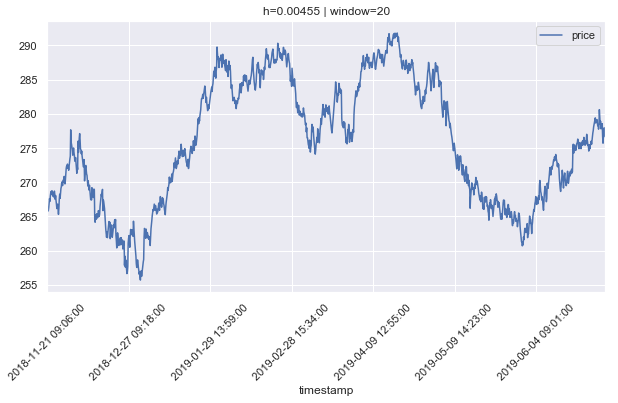

In [280]:
df = pd.read_csv('dollar_D_15.csv',index_col='timestamp')

dVol = getDailityVol(df,span=20,col_close='price')
dVol = dVol.fillna(0)
fl_idx = cusum_filter_dailyVol(df, dVol , time_stamps=False)
s_t_2 = df[df.index.isin(fl_idx)]

s_t_2.plot(
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
    figsize=figsize,
    title='h=' + str(h_t) + ' | window='+str(window)
)
display(s_t_2.index.size)

r2 =s_t_2['price'].pct_change()
display(r2.autocorr(lag=1))

더 많은 이벤트를 감지하지만, autocorr은 더 낮아졌다.

## [EXERCISES 3.1.b](#top)<a name='e_3_1_b'></a>
Use Snippet 3.4 on a pandas series ```t1```, where ```numDays = 1```

In [18]:
# Snippet 3.4 page 49, Adding a Vertical Barrier
def add_vertical_barrier(t_events, close, num_days=0, num_hours=0, num_minutes=0, num_seconds=0):
    """
    Snippet 3.4 page 49, Adding a Vertical Barrier
    For each index in t_events, it finds the timestamp of the next price bar at or immediately after
    a number of days num_days. This vertical barrier can be passed as an optional argument t1 in get_events.
    This function creates a series that has all the timestamps of when the vertical barrier would be reached.
    :param t_events: (series) series of events (symmetric CUSUM filter)
    :param close: (series) close prices
    :param num_days: (int) number of days to add for vertical barrier
    :param num_hours: (int) number of hours to add for vertical barrier
    :param num_minutes: (int) number of minutes to add for vertical barrier
    :param num_seconds: (int) number of seconds to add for vertical barrier
    :return: (series) timestamps of vertical barriers
    """
    timedelta = pd.Timedelta(
        '{} days, {} hours, {} minutes, {} seconds'.format(num_days, num_hours, num_minutes, num_seconds))
    # Find index to closest to vertical barrier
    nearest_index = close.index.searchsorted(t_events + timedelta)

    # Exclude indexes which are outside the range of close price index
    nearest_index = nearest_index[nearest_index < close.shape[0]]

    # Find price index closest to vertical barrier time stamp
    nearest_timestamp = close.index[nearest_index]
    filtered_events = t_events[:nearest_index.shape[0]]

    vertical_barriers = pd.Series(data=nearest_timestamp, index=filtered_events)
    return vertical_barriers

1370

-0.02346663418157136

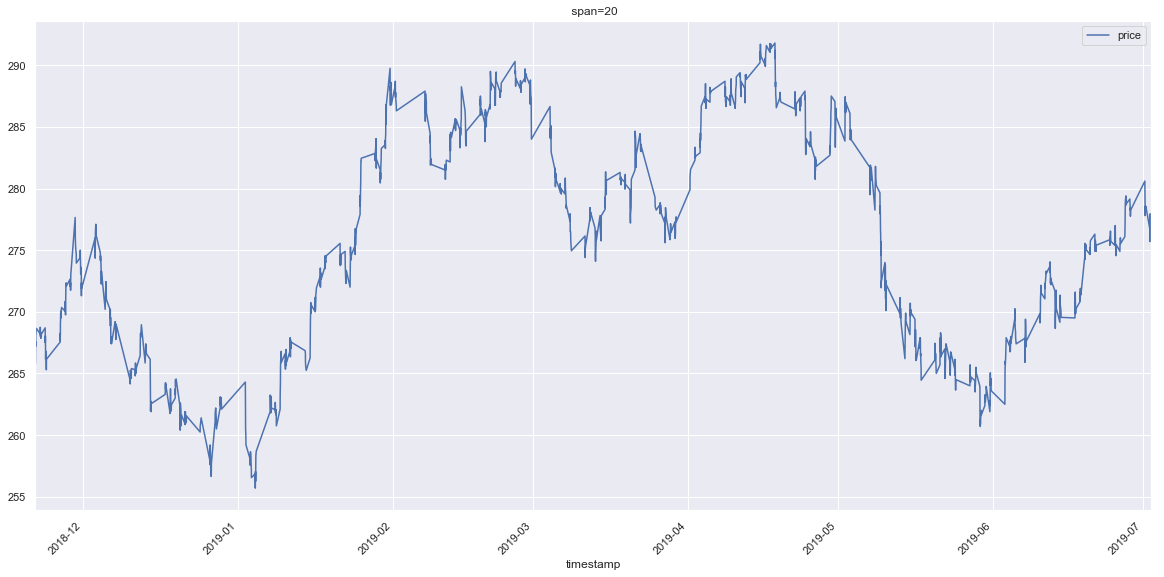

In [22]:
figsize=(20,10)
span = 20


df = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
df.index = pd.to_datetime(df.index)

dVol = getDailityVol(df,span=span,col_close='price')
dVol = dVol.fillna(0)

fl_idx = cusum_filter_dailyVol(df, dVol , time_stamps=True)
df_event = df[df.index.isin(fl_idx)]

v = add_vertical_barrier(fl_idx,df['price'],num_days=1)

df_event.plot(
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
    figsize=figsize,
    title=' span='+str(span)
)
display(df_event.index.size)

ret =df_event['price'].pct_change()
display(ret.autocorr(lag=1))

## [EXERCISES 3.1.c](#top)<a name='e_3_1_c'></a>
On those sampled features, applay the triple-barrier method, where ```psS1=[1,1]``` and ```t1``` is the series you crated in point 1.b

[mlfinlab](https://github.com/hudson-and-thames/mlfinlab/blob/master/mlfinlab/tests/test_labels.py)


In [53]:
df = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
df.index = pd.to_datetime(df.index)
data = df.price
span = 20
threshold = 0.0125

daily_vol = get_daily_vol(close=data, lookback=span)
cusum_events = cusum_filter(data, threshold=threshold)
vertical_barriers = add_vertical_barrier(t_events=cusum_events, close=data, num_days=1)

# No meta-labeling
triple_barrier_events = get_events(close=data,
                               t_events=cusum_events,
                               pt_sl=[1, 1],
                               target=daily_vol,
                               min_ret=0.005,
                               num_threads=3,
                               vertical_barrier_times=vertical_barriers,
                               side_prediction=None)


2019-07-28 14:54:25.769527 100.0% apply_pt_sl_on_t1 done after 0.04 minutes. Remaining 0.0 minutes..


47

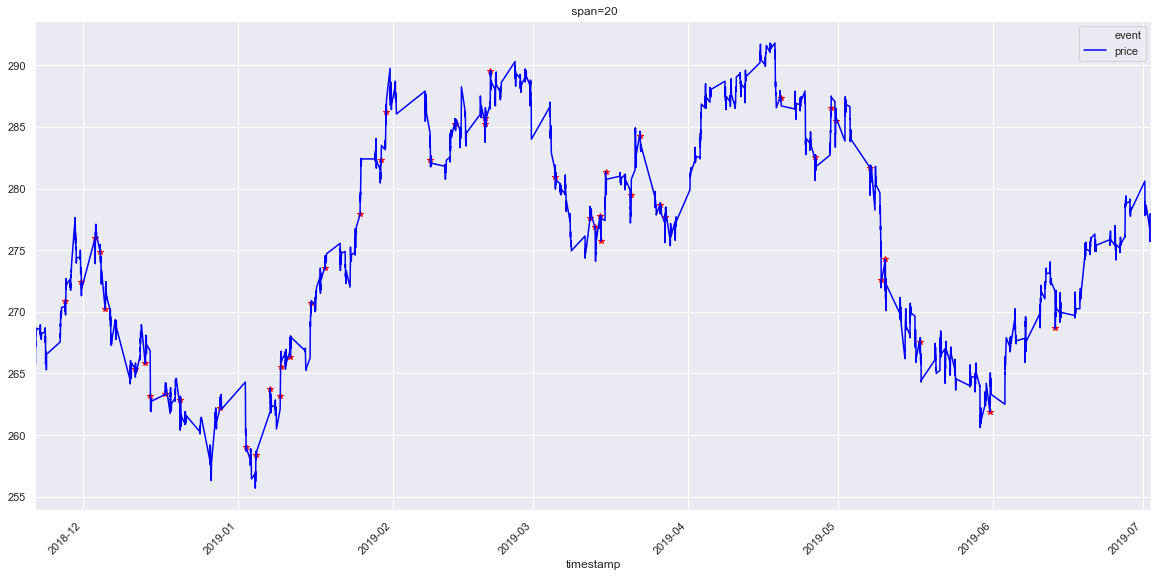

In [67]:
%matplotlib inline

figsize=(20,10)

df_event = df[df.index.isin(triple_barrier_events.t1)]
df_event.columns=['event']
ax = df_event.plot(
    style='*',
    color='red',
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
    figsize=figsize,
    title=' span='+str(span)
)
df.plot(
    style='-',
    color='blue',
    ax=ax,
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
    figsize=figsize,
)
display(df_event.index.size)

## EXERCISES 3.1.d<a name='e_3_1_d'></a>
Apply ```getBins``` to generate lables

In [3]:
df = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
df.index = pd.to_datetime(df.index)
data = df.price
span = 20
threshold = 0.0125

daily_vol = get_daily_vol(close=data, lookback=span)
cusum_events = cusum_filter(data, threshold=threshold)
vertical_barriers = add_vertical_barrier(t_events=cusum_events, close=data, num_days=1)

# No meta-labeling
triple_barrier_events = get_events(close=data,
                               t_events=cusum_events,
                               pt_sl=[1, 1],
                               target=daily_vol,
                               min_ret=0.005,
                               num_threads=3,
                               vertical_barrier_times=vertical_barriers,
                               side_prediction=None)
triple_labels = get_bins(triple_barrier_events, data)

2019-07-28 15:32:16.401647 100.0% apply_pt_sl_on_t1 done after 0.04 minutes. Remaining 0.0 minutes..


In [4]:
def plot_star(df,color,ax):
    return df.plot(
    style='*',
    color=color,
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
    ax=ax
    )

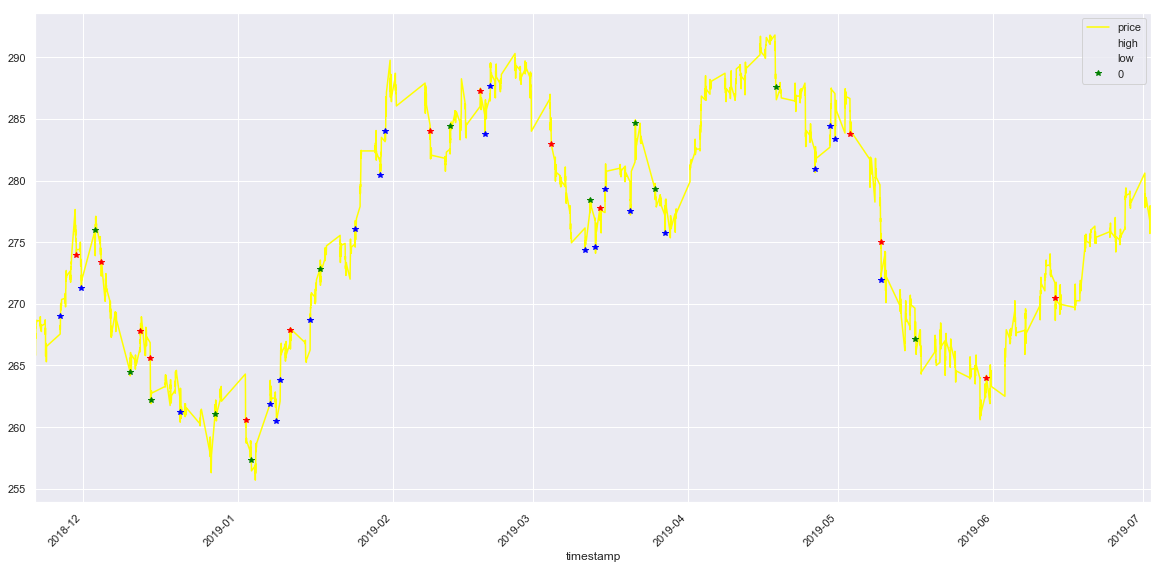

In [11]:
%matplotlib inline

figsize=(20,10)

df_event = df[df.index.isin(triple_labels.index)]
df_event.columns=['event']

ax= df.plot(
    style='-',
    color='yellow',
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
    figsize=figsize,
)

triple_labels.head()

p1 = triple_labels.loc[triple_labels['bin'] == 1]
m1 = triple_labels.loc[triple_labels['bin'] == -1]
z0 = triple_labels.loc[triple_labels['bin'] == 0]

df_p1 = df[df.index.isin(p1.index)]
df_p1.columns=['high']
df_m1 = df[df.index.isin(m1.index)]
df_m1.columns=['low']
df_z0 = df[df.index.isin(z0.index)]
df_z0.columns=['0']

plot_star(df_p1,color='blue',ax=ax)
plot_star(df_m1,color='red',ax=ax)
plot_star(df_z0,color='green',ax=ax)